In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import time
import random
from tqdm.notebook import tqdm
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical

# np.random.seed(42)
# random.seed(42)
# setting seed for reproducibility

## Task 1: Acquire Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Load training set (60K images)
X_tr = np.load("/content/drive/MyDrive/kmnist-train-imgs.npz")["arr_0"].reshape(-1, 784) / 255.0
y_tr = np.load("/content/drive/MyDrive/kmnist-train-labels.npz")["arr_0"]
X_te = np.load("/content/drive/MyDrive/kmnist-test-imgs.npz")["arr_0"].reshape(-1, 784) / 255.0
y_te = np.load("/content/drive/MyDrive/kmnist-test-labels.npz")["arr_0"]

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X_tr, y_tr, test_size=0.2)

In [ ]:
print(X_train.shape[1])

784


In [ ]:
INPUT_SIZE = X_tr[0].shape[0]
OUTPUT_SIZE = 10

In [ ]:
def one_hot_encode(y, num_classes=10):
    one_hot = np.zeros((y.size, num_classes))
    one_hot[np.arange(y.size), y] = 1
    return one_hot

# function to one hot encode labels for gradient checking

In [ ]:
y_train_one_hot = one_hot_encode(y_train)

In [ ]:
y_train_one_hot

array([[0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.]])

## Task 2: Implement MLP

In [ ]:
class MLP:
    def __init__(self, layer_sizes, activation="relu", seed=None):
        """
        layer_sizes: list of units per layer, including input and output, e.g., [784, 64, 64, 10]
        activation: activation function name ("relu" or "sigmoid")
        """
        if seed:
            np.random.seed(seed)

        self.layer_sizes = layer_sizes
        self.num_layers = len(layer_sizes) - 1
        self.activation_name = activation
        self.alpha = 0.01
        self.training_accuracy = []

        # initialize weights and biases
        self.weights = []
        self.biases = []
        for i in range(self.num_layers):
            weight = np.random.randn(layer_sizes[i], layer_sizes[i+1]) * np.sqrt(2. / layer_sizes[i])
            bias = np.zeros((1, layer_sizes[i+1]))
            self.weights.append(weight)
            self.biases.append(bias)

    def _activation(self, x):
        if self.activation_name == "relu":
            return np.maximum(0, x)
        elif self.activation_name == "sigmoid":
            return 1. / (1 + np.exp(-x))
        else:
#             leaky relu
# use alpha = 0.01
            return np.where(x >= 0, x, self.alpha*x)

    def _activation_deriv(self, x):
        if self.activation_name == "relu":
            return (x > 0).astype(float)
        elif self.activation_name == "sigmoid":
            sig = 1. / (1 + np.exp(-x))
            return sig * (1 - sig)
        else:
            return np.where(x >= 0, 1, self.alpha)

    def _softmax(self, z):
        exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))  # for numerical stability
        return exp_z / np.sum(exp_z, axis=1, keepdims=True)

    def _one_hot(self, y, num_classes):
        one_hot = np.zeros((y.size, num_classes))
        one_hot[np.arange(y.size), y] = 1
        return one_hot

    def fit(self, X, y, learning_rate=0.01, epochs=10, batch_size=64, lambda_param=0.0):
        m = X.shape[0]
        self.lambda_param = lambda_param
        y_onehot = self._one_hot(y, self.layer_sizes[-1])

        for epoch in tqdm(range(epochs)):
            indices = np.arange(m)
            np.random.shuffle(indices)
            X_shuffled = X[indices]
            y_shuffled = y_onehot[indices]

            for i in range(0, m, batch_size):
                X_batch = X_shuffled[i:i+batch_size]
                y_batch = y_shuffled[i:i+batch_size]

                # forward pass
                activations = [X_batch]
                zs = []
                for l in range(self.num_layers - 1):
                    z = activations[-1] @ self.weights[l] + self.biases[l]
                    zs.append(z)
                    a = self._activation(z)
                    activations.append(a)

                # softmax
                z_out = activations[-1] @ self.weights[-1] + self.biases[-1]
                zs.append(z_out)
                a_out = self._softmax(z_out)
                activations.append(a_out)

                # backward pass
                delta = (a_out - y_batch) / batch_size
                dW = [0] * self.num_layers
                dB = [0] * self.num_layers

                dW[-1] = activations[-2].T @ delta
                dB[-1] = np.sum(delta, axis=0, keepdims=True)

                for l in range(self.num_layers - 2, -1, -1):
                    delta = (delta @ self.weights[l+1].T) * self._activation_deriv(zs[l])
                    dW[l] = activations[l].T @ delta
                    dB[l] = np.sum(delta, axis=0, keepdims=True)

                # update weights and biases
                for l in range(self.num_layers):
                    dW[l] += self.lambda_param * self.weights[l]  # L2 regularization term
                    self.weights[l] -= learning_rate * dW[l]
                    self.biases[l] -= learning_rate * dB[l]

            # print progress
            if epoch % 1 == 0:
                preds = self.predict(X)
                acc = self.evaluate_acc(y, preds)
                self.training_accuracy.append(acc)
                print(f"Epoch {epoch+1}/{epochs} - Accuracy: {acc:.4f}")
        return self

    def predict(self, X):
        a = X
        for l in range(self.num_layers - 1):
            z = a @ self.weights[l] + self.biases[l]
            a = self._activation(z)
        z_out = a @ self.weights[-1] + self.biases[-1]
        probs = self._softmax(z_out)
        return np.argmax(probs, axis=1)

    def evaluate_acc(self, y_true, y_pred):
        return np.mean(y_true == y_pred)

In [ ]:
def check_gradient(self, x, y, num_fts):
    diffs = {}
    for pair in zip(self.weights, range(num_fts)):
#         need feature name only for printing/storing
        w = pair[0]
        ft = pair[1]
        xd = x[:,ft]
        w0 = w
        epsilon = np.random.randn(1)[0]*1e-5
#         generate small perturbation factor from a normal distribution
        w_plus = w0 + epsilon
        w_minus = w0 - epsilon
        a1 = xd * w_plus
        a2 = xd * w_minus
        ce1 = np.sum(y * np.log1p(np.exp(-a1)) + (1-y) * np.log1p(np.exp(a1)))
        ce2 = np.sum(y * np.log1p(np.exp(-a2)) + (1-y) * np.log1p(np.exp(a2)))
#         these two lines compute the loss J(w) with the perturbations
        delta_w = (ce1-ce2)/(2*epsilon)
#     numerical gradient
        yhat = 1/(1+np.exp(-xd * w))
        dw_cal = np.sum((yhat - y) * xd) # hand calculated/analytical gradient
        result = (dw_cal - delta_w)**2/(dw_cal + delta_w)**2
        diffs[ft] = result
    return diffs

MLP.check_gradient = check_gradient

In [ ]:
def plot_accuracy(model):
  plt.clf()
  plt.plot(range(1,len(model.training_accuracy)+1), model.training_accuracy)
  plt.title('Training accuracy as function of epochs')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')

## Task 3: Run experiments

#### Let us determine the best learning rate to use for our models (Note 2)

In [ ]:
rates = [0.1, 0.01, 0.001]
rate_accuracies = {}
for r in rates:
    model = MLP([INPUT_SIZE, 16, 16, 10], 'relu', 42)
    preds = model.fit(X_train, y_train, learning_rate=r).predict(X_val)
    acc = model.evaluate_acc(preds, y_val)
    rate_accuracies[r] = acc

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10 - Accuracy: 0.8433
Epoch 2/10 - Accuracy: 0.8712
Epoch 3/10 - Accuracy: 0.8942
Epoch 4/10 - Accuracy: 0.9035
Epoch 5/10 - Accuracy: 0.9071
Epoch 6/10 - Accuracy: 0.9068
Epoch 7/10 - Accuracy: 0.9134
Epoch 8/10 - Accuracy: 0.9164
Epoch 9/10 - Accuracy: 0.9156
Epoch 10/10 - Accuracy: 0.9205


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10 - Accuracy: 0.6785
Epoch 2/10 - Accuracy: 0.7830
Epoch 3/10 - Accuracy: 0.8229
Epoch 4/10 - Accuracy: 0.8415
Epoch 5/10 - Accuracy: 0.8527
Epoch 6/10 - Accuracy: 0.8620
Epoch 7/10 - Accuracy: 0.8676
Epoch 8/10 - Accuracy: 0.8731
Epoch 9/10 - Accuracy: 0.8741
Epoch 10/10 - Accuracy: 0.8805


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10 - Accuracy: 0.2103
Epoch 2/10 - Accuracy: 0.2640
Epoch 3/10 - Accuracy: 0.3530
Epoch 4/10 - Accuracy: 0.4335
Epoch 5/10 - Accuracy: 0.4954
Epoch 6/10 - Accuracy: 0.5411
Epoch 7/10 - Accuracy: 0.5850
Epoch 8/10 - Accuracy: 0.6332
Epoch 9/10 - Accuracy: 0.6682
Epoch 10/10 - Accuracy: 0.6912


In [ ]:
rate_accuracies

{0.1: np.float64(0.89375),
 0.01: np.float64(0.8660833333333333),
 0.001: np.float64(0.6934166666666667)}

So it seems that a learning rate of $\alpha=0.1$ works best

### 3.1

In [ ]:
results = {'hidden layers': [], 'number of units': [], 'accuracy': []}

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10 - Accuracy: 0.8093
Epoch 2/10 - Accuracy: 0.8186
Epoch 3/10 - Accuracy: 0.8251
Epoch 4/10 - Accuracy: 0.8279
Epoch 5/10 - Accuracy: 0.8309
Epoch 6/10 - Accuracy: 0.8294
Epoch 7/10 - Accuracy: 0.8327
Epoch 8/10 - Accuracy: 0.8319
Epoch 9/10 - Accuracy: 0.8334
Epoch 10/10 - Accuracy: 0.8349
0.6952


Text(0, 0.5, 'Accuracy')

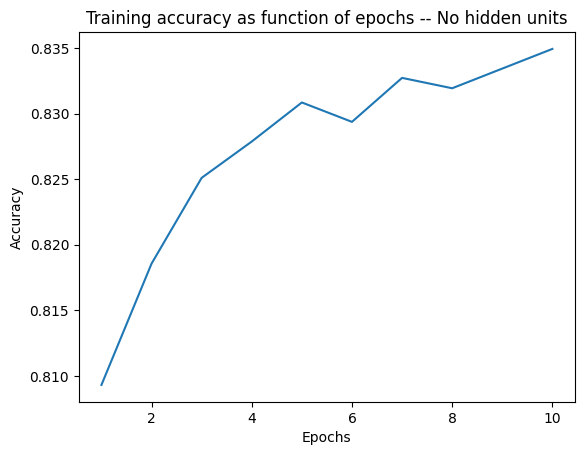

In [ ]:
no_hidden = MLP(layer_sizes=[INPUT_SIZE,OUTPUT_SIZE], activation='relu', seed=42)
preds_no_hidden = no_hidden.fit(X=X_train, y=y_train, learning_rate=0.1).predict(X_te)
no_hidden_acc = no_hidden.evaluate_acc(y_te, preds_no_hidden)
results['hidden layers'].append(0)
results['number of units'].append(0)
results['accuracy'].append(no_hidden_acc)
print(no_hidden_acc)
plt.clf()
plt.plot(range(1,len(no_hidden.training_accuracy)+1), no_hidden.training_accuracy)
plt.title('Training accuracy as function of epochs -- No hidden units')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

In [ ]:
for l in [1,2]:
    for u in [32,64,128,256]:
        layer_sizes = [INPUT_SIZE] + [u]*l + [OUTPUT_SIZE]
        mlp = MLP(layer_sizes=layer_sizes, activation='relu', seed=42)
        preds = mlp.fit(X=X_train, y=y_train, learning_rate=0.1).predict(X_te)
        acc = mlp.evaluate_acc(y_te, preds)
        results['hidden layers'].append(l)
        results['number of units'].append(u)
        results['accuracy'].append(acc)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10 - Accuracy: 0.8701
Epoch 2/10 - Accuracy: 0.8972
Epoch 3/10 - Accuracy: 0.9130
Epoch 4/10 - Accuracy: 0.9236
Epoch 5/10 - Accuracy: 0.9302
Epoch 6/10 - Accuracy: 0.9369
Epoch 7/10 - Accuracy: 0.9397
Epoch 8/10 - Accuracy: 0.9401
Epoch 9/10 - Accuracy: 0.9454
Epoch 10/10 - Accuracy: 0.9480


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10 - Accuracy: 0.8822
Epoch 2/10 - Accuracy: 0.9093
Epoch 3/10 - Accuracy: 0.9287
Epoch 4/10 - Accuracy: 0.9383
Epoch 5/10 - Accuracy: 0.9439
Epoch 6/10 - Accuracy: 0.9515
Epoch 7/10 - Accuracy: 0.9585
Epoch 8/10 - Accuracy: 0.9625
Epoch 9/10 - Accuracy: 0.9607
Epoch 10/10 - Accuracy: 0.9674


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10 - Accuracy: 0.8850
Epoch 2/10 - Accuracy: 0.9199
Epoch 3/10 - Accuracy: 0.9388
Epoch 4/10 - Accuracy: 0.9477
Epoch 5/10 - Accuracy: 0.9580
Epoch 6/10 - Accuracy: 0.9645
Epoch 7/10 - Accuracy: 0.9693
Epoch 8/10 - Accuracy: 0.9750
Epoch 9/10 - Accuracy: 0.9785
Epoch 10/10 - Accuracy: 0.9811


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10 - Accuracy: 0.8964
Epoch 2/10 - Accuracy: 0.9259
Epoch 3/10 - Accuracy: 0.9471
Epoch 4/10 - Accuracy: 0.9570
Epoch 5/10 - Accuracy: 0.9632
Epoch 6/10 - Accuracy: 0.9722
Epoch 7/10 - Accuracy: 0.9783
Epoch 8/10 - Accuracy: 0.9792
Epoch 9/10 - Accuracy: 0.9859
Epoch 10/10 - Accuracy: 0.9881


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10 - Accuracy: 0.8885
Epoch 2/10 - Accuracy: 0.9159
Epoch 3/10 - Accuracy: 0.9300
Epoch 4/10 - Accuracy: 0.9383
Epoch 5/10 - Accuracy: 0.9372
Epoch 6/10 - Accuracy: 0.9417
Epoch 7/10 - Accuracy: 0.9507
Epoch 8/10 - Accuracy: 0.9532
Epoch 9/10 - Accuracy: 0.9523
Epoch 10/10 - Accuracy: 0.9581


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10 - Accuracy: 0.8994
Epoch 2/10 - Accuracy: 0.9282
Epoch 3/10 - Accuracy: 0.9393
Epoch 4/10 - Accuracy: 0.9522
Epoch 5/10 - Accuracy: 0.9632
Epoch 6/10 - Accuracy: 0.9669
Epoch 7/10 - Accuracy: 0.9689
Epoch 8/10 - Accuracy: 0.9761
Epoch 9/10 - Accuracy: 0.9791
Epoch 10/10 - Accuracy: 0.9810


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10 - Accuracy: 0.9068
Epoch 2/10 - Accuracy: 0.9442
Epoch 3/10 - Accuracy: 0.9591
Epoch 4/10 - Accuracy: 0.9706
Epoch 5/10 - Accuracy: 0.9691
Epoch 6/10 - Accuracy: 0.9800
Epoch 7/10 - Accuracy: 0.9831
Epoch 8/10 - Accuracy: 0.9854
Epoch 9/10 - Accuracy: 0.9915
Epoch 10/10 - Accuracy: 0.9938


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10 - Accuracy: 0.9175
Epoch 2/10 - Accuracy: 0.9523
Epoch 3/10 - Accuracy: 0.9665
Epoch 4/10 - Accuracy: 0.9766
Epoch 5/10 - Accuracy: 0.9788
Epoch 6/10 - Accuracy: 0.9868
Epoch 7/10 - Accuracy: 0.9928
Epoch 8/10 - Accuracy: 0.9955
Epoch 9/10 - Accuracy: 0.9975
Epoch 10/10 - Accuracy: 0.9987


In [ ]:
# now we display the results as a dataframe
results_df = pd.DataFrame(results)
display(results_df)

,hidden layers,number of units,accuracy
0,0,0,0.6952
1,1,32,0.8287
2,1,64,0.8487
3,1,128,0.8724
4,1,256,0.8865
5,2,32,0.8326
6,2,64,0.8688
7,2,128,0.8806
8,2,256,0.8990


### 3.2

Since the two-layer model with 256 units has the highest accuracy on the testing set, we will use this model for this sub-experiment

In [ ]:
results_2 = {'hidden layers': [], 'number of units': [], 'activation function': [], 'accuracy': []}
results_2['hidden layers'].append(2)
results_2['number of units'].append(256)
results_2['activation function'].append('ReLU')
results_2['accuracy'].append(0.9039)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10 - Accuracy: 0.7521
Epoch 2/10 - Accuracy: 0.8053
Epoch 3/10 - Accuracy: 0.8210
Epoch 4/10 - Accuracy: 0.8417
Epoch 5/10 - Accuracy: 0.8502
Epoch 6/10 - Accuracy: 0.8675
Epoch 7/10 - Accuracy: 0.8787
Epoch 8/10 - Accuracy: 0.8893
Epoch 9/10 - Accuracy: 0.8982
Epoch 10/10 - Accuracy: 0.9066


Text(0, 0.5, 'Accuracy')

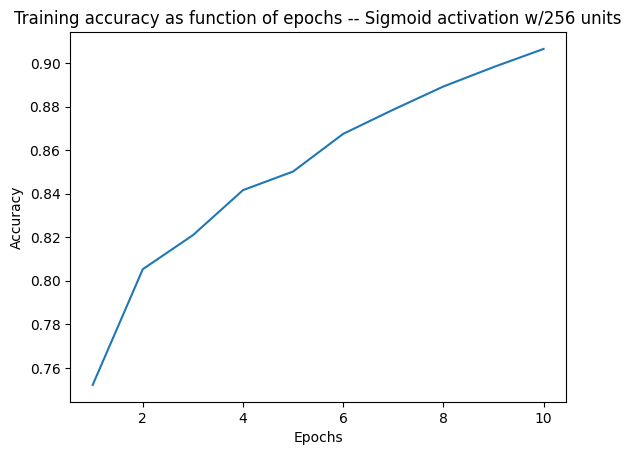

In [ ]:
sigmoid_mlp = MLP(layer_sizes=[INPUT_SIZE, 256, 256, OUTPUT_SIZE], activation='sigmoid', seed=42)
sigmoid_preds = sigmoid_mlp.fit(X=X_train, y=y_train, learning_rate=0.1).predict(X_te)
sigmoid_acc = sigmoid_mlp.evaluate_acc(y_te, sigmoid_preds)
results_2['hidden layers'].append(2)
results_2['number of units'].append(256)
results_2['activation function'].append('Sigmoid')
results_2['accuracy'].append(sigmoid_acc)

plt.clf()
plt.plot(range(1,len(sigmoid_mlp.training_accuracy)+1), sigmoid_mlp.training_accuracy)
plt.title('Training accuracy as function of epochs -- Sigmoid activation w/256 units')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10 - Accuracy: 0.9166
Epoch 2/10 - Accuracy: 0.9517
Epoch 3/10 - Accuracy: 0.9661
Epoch 4/10 - Accuracy: 0.9757
Epoch 5/10 - Accuracy: 0.9774
Epoch 6/10 - Accuracy: 0.9851
Epoch 7/10 - Accuracy: 0.9923
Epoch 8/10 - Accuracy: 0.9952
Epoch 9/10 - Accuracy: 0.9975
Epoch 10/10 - Accuracy: 0.9987


Text(0, 0.5, 'Accuracy')

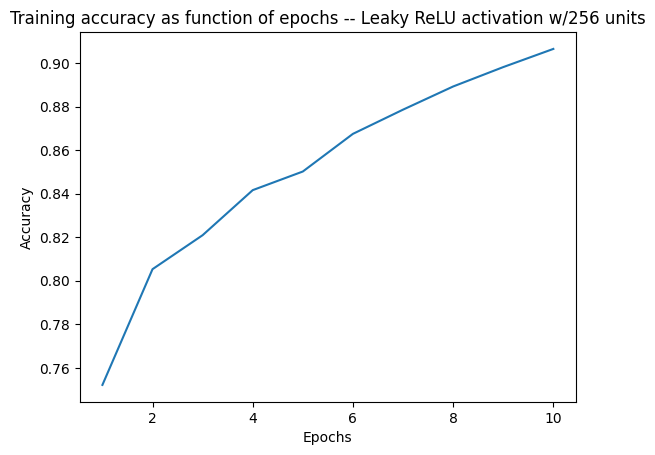

In [ ]:
leaky_mlp = MLP(layer_sizes=[INPUT_SIZE, 256, 256, OUTPUT_SIZE], activation='leaky', seed=42)
leaky_preds = leaky_mlp.fit(X=X_train, y=y_train, learning_rate=0.1).predict(X_te)
leaky_acc = leaky_mlp.evaluate_acc(y_te, leaky_preds)
results_2['hidden layers'].append(2)
results_2['number of units'].append(256)
results_2['activation function'].append('Leaky ReLU')
results_2['accuracy'].append(leaky_acc)

plt.clf()
plt.plot(range(1,len(sigmoid_mlp.training_accuracy)+1), sigmoid_mlp.training_accuracy)
plt.title('Training accuracy as function of epochs -- Leaky ReLU activation w/256 units')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

In [ ]:
results_df_2 = pd.DataFrame(results_2)
display(results_df_2)

,hidden layers,number of units,activation function,accuracy
0,2,256,ReLU,0.9039
1,2,256,Sigmoid,0.7872
2,2,256,Leaky ReLU,0.8989


### 3.3 Add L2 Regularization

Here we will add L2 regularization to our MLP model, and adjust $\lambda$ as a hyperparameter and see which value performs best on the validation set. We will then take the best performing $\lambda$ and then see how this affects the accuracy on the test set.

In [ ]:
l2 = [1e-2, 1e-3, 1e-4]
lambda_accuracies = {}
for lambda_param in l2:
    model = MLP(layer_sizes=[INPUT_SIZE, 256, 256, OUTPUT_SIZE], activation='relu', seed=42)
    preds = model.fit(X=X_train, y=y_train, learning_rate=0.1, lambda_param=lambda_param).predict(X_val)
    acc = model.evaluate_acc(y_val, preds)
    lambda_accuracies[lambda_param] = acc

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10 - Accuracy: 0.8831
Epoch 2/10 - Accuracy: 0.9006
Epoch 3/10 - Accuracy: 0.9068
Epoch 4/10 - Accuracy: 0.9050
Epoch 5/10 - Accuracy: 0.9155
Epoch 6/10 - Accuracy: 0.9157
Epoch 7/10 - Accuracy: 0.9167
Epoch 8/10 - Accuracy: 0.9258
Epoch 9/10 - Accuracy: 0.9157
Epoch 10/10 - Accuracy: 0.9222


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10 - Accuracy: 0.9141
Epoch 2/10 - Accuracy: 0.9428
Epoch 3/10 - Accuracy: 0.9587
Epoch 4/10 - Accuracy: 0.9674
Epoch 5/10 - Accuracy: 0.9763
Epoch 6/10 - Accuracy: 0.9758
Epoch 7/10 - Accuracy: 0.9809
Epoch 8/10 - Accuracy: 0.9862
Epoch 9/10 - Accuracy: 0.9860
Epoch 10/10 - Accuracy: 0.9894


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10 - Accuracy: 0.9164
Epoch 2/10 - Accuracy: 0.9474
Epoch 3/10 - Accuracy: 0.9657
Epoch 4/10 - Accuracy: 0.9729
Epoch 5/10 - Accuracy: 0.9835
Epoch 6/10 - Accuracy: 0.9843
Epoch 7/10 - Accuracy: 0.9897
Epoch 8/10 - Accuracy: 0.9937
Epoch 9/10 - Accuracy: 0.9928
Epoch 10/10 - Accuracy: 0.9975


In [ ]:
display(lambda_accuracies)

{0.01: np.float64(0.90725),
 0.001: np.float64(0.9535),
 0.0001: np.float64(0.9563333333333334)}

From the above results it seems that the best value for L2 regularization is $\lambda=0.0001$ going forward

In [ ]:
lambdas_df = pd.DataFrame({'lambda': lambda_accuracies.keys(), 'accuracy': lambda_accuracies.values()})
display(lambdas_df)

,lambda,accuracy
0,0.0100,0.907250
1,0.0010,0.953500
2,0.0001,0.956333


Now train a 2 layer MLP with 256 units and a $\lambda$ of 0.0001

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10 - Accuracy: 0.9164
Epoch 2/10 - Accuracy: 0.9474
Epoch 3/10 - Accuracy: 0.9657
Epoch 4/10 - Accuracy: 0.9729
Epoch 5/10 - Accuracy: 0.9835
Epoch 6/10 - Accuracy: 0.9843
Epoch 7/10 - Accuracy: 0.9897
Epoch 8/10 - Accuracy: 0.9937
Epoch 9/10 - Accuracy: 0.9928
Epoch 10/10 - Accuracy: 0.9975
0.9009


Text(0, 0.5, 'Accuracy')

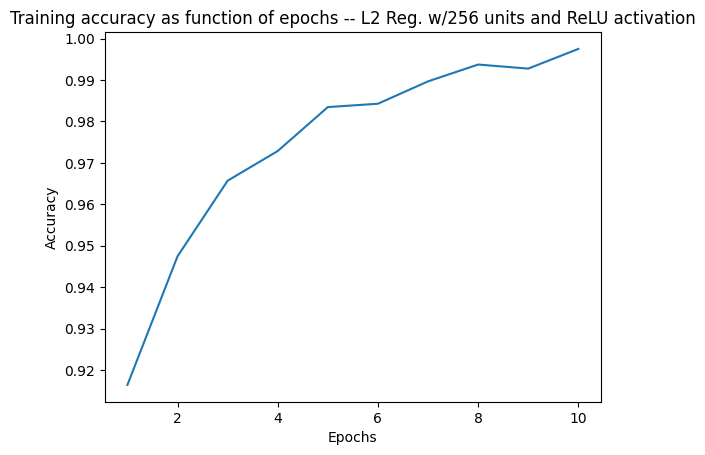

In [ ]:
mlp_l2_final = MLP(layer_sizes=[INPUT_SIZE, 256, 256, OUTPUT_SIZE], activation='relu', seed=42)
preds = mlp_l2_final.fit(X=X_train, y=y_train, learning_rate=0.1, lambda_param=1e-4).predict(X_te)
acc = mlp_l2_final.evaluate_acc(y_te, preds)
print(acc)

plt.clf()
plt.plot(range(1,len(mlp_l2_final.training_accuracy)+1), mlp_l2_final.training_accuracy)
plt.title('Training accuracy as function of epochs -- L2 Reg. w/256 units and ReLU activation')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

### 3.3 Use a CNN as a point of comparison


In [ ]:
X_tr_cnn = np.load("/content/drive/MyDrive/kmnist-train-imgs.npz")["arr_0"]
y_tr_cnn = np.load("/content/drive/MyDrive/kmnist-train-labels.npz")["arr_0"]
X_te_cnn = np.load("/content/drive/MyDrive/kmnist-test-imgs.npz")["arr_0"]
y_te_cnn = np.load("/content/drive/MyDrive/kmnist-test-labels.npz")["arr_0"]

In [ ]:
X_train_cnn, X_val_cnn, y_train_cnn, y_val_cnn = train_test_split(X_tr_cnn, y_tr_cnn, test_size=0.2)

In [ ]:
y_train_cnn = to_categorical(y_train_cnn, num_classes=10)
y_val_cnn = to_categorical(y_val_cnn, num_classes=10)
y_test_cnn = to_categorical(y_te_cnn, num_classes=10)

In [ ]:
def create_model(hidden_units):
    model = keras.Sequential([
        layers.Conv2D(64, (3,3), activation='relu', input_shape=(28,28,1)),
        layers.MaxPooling2D((2,2)),
        layers.Conv2D(64, (3,3), activation='relu'),
        layers.MaxPooling2D((2,2)),
        layers.Conv2D(64, (3,3), activation='relu'),
        layers.Flatten(),
        layers.Dense(hidden_units, activation='relu'),
        layers.Dense(10, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
validation_accuracy = {'units': [], 'accuracy': []}
units = [32,64,128,256]
start = time.time()
for u in units:
  model = create_model(hidden_units=u)
  model.fit(X_train_cnn, y_train_cnn, epochs=10, batch_size=64)
  test_loss, val_acc = model.evaluate(X_val_cnn, y_val_cnn)
  validation_accuracy['units'].append(u)
  validation_accuracy['accuracy'].append(val_acc)
end = time.time()
print(f'Total elapsed time: {end-start}')

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 67s 86ms/step - accuracy: 0.5830 - loss: 1.4495
Epoch 2/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 79s 82ms/step - accuracy: 0.9420 - loss: 0.1932
Epoch 3/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 82s 82ms/step - accuracy: 0.9656 - loss: 0.1094
Epoch 4/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 63s 84ms/step - accuracy: 0.9757 - loss: 0.0811
Epoch 5/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 83s 85ms/step - accuracy: 0.9824 - loss: 0.0577
Epoch 6/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 81s 83ms/step - accuracy: 0.9842 - loss: 0.0475
Epoch 7/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 85s 87ms/step - accuracy: 0.9872 - loss: 0.0404
Epoch 8/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 78s 82ms/step - accuracy: 0.9892 - loss: 0.0344
Epoch 9/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 83s 83ms/step - accuracy: 0.9899 - loss: 0.0303
Epoch 10/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 82s 84ms/step - accuracy: 0.9903 - loss: 0.0270
375/375 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.9774 - loss: 0.1011
Epoch 1/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 66s

In [ ]:
validation_accuracy

{'units': [32, 64, 128, 256],
 'accuracy': [0.9754999876022339,
  0.9729166626930237,
  0.9750000238418579,
  0.9729166626930237]}

In [ ]:
validation_acc_df = pd.DataFrame(validation_accuracy)
display(validation_acc_df)

,units,accuracy
0,32,0.975500
1,64,0.972917
2,128,0.975000
3,256,0.972917


Since the model with 32 units has the highest accuracy on the validation set, we will use that on the test set

In [ ]:
HIDDEN_UNITS = 32
model = keras.Sequential([
        layers.Conv2D(64, (3,3), activation='relu', input_shape=(28,28,1)),
        layers.MaxPooling2D((2,2)),
        layers.Conv2D(64, (3,3), activation='relu'),
        layers.MaxPooling2D((2,2)),
        layers.Conv2D(64, (3,3), activation='relu'),
        layers.Flatten(),
        layers.Dense(HIDDEN_UNITS, activation='relu'),
        layers.Dense(10, activation='softmax')
    ])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model_history = model.fit(X_train_cnn, y_train_cnn, epochs=10, batch_size=64)
test_loss, test_acc = model.evaluate(X_te_cnn, y_test_cnn)
print(test_acc)

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


750/750 ━━━━━━━━━━━━━━━━━━━━ 69s 90ms/step - accuracy: 0.6180 - loss: 1.5283
Epoch 2/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 68s 90ms/step - accuracy: 0.9383 - loss: 0.2048
Epoch 3/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 64s 86ms/step - accuracy: 0.9648 - loss: 0.1162
Epoch 4/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 67s 89ms/step - accuracy: 0.9733 - loss: 0.0873
Epoch 5/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 83s 91ms/step - accuracy: 0.9790 - loss: 0.0721
Epoch 6/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 79s 87ms/step - accuracy: 0.9826 - loss: 0.0567
Epoch 7/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 81s 86ms/step - accuracy: 0.9841 - loss: 0.0490
Epoch 8/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 67s 89ms/step - accuracy: 0.9886 - loss: 0.0364
Epoch 9/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 83s 90ms/step - accuracy: 0.9883 - loss: 0.0350
Epoch 10/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 81s 90ms/step - accuracy: 0.9894 - loss: 0.0339
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.9239 - loss: 0.4055
0.9269000291824341


In [ ]:
model_history.history

{'accuracy': [0.7894791960716248,
  0.9434791803359985,
  0.965541660785675,
  0.9727916717529297,
  0.9783124923706055,
  0.9808541536331177,
  0.9837083220481873,
  0.9871041774749756,
  0.9867083430290222,
  0.9887708425521851],
 'loss': [0.7225726842880249,
  0.18813753128051758,
  0.11502493172883987,
  0.08731294423341751,
  0.07122907042503357,
  0.06261581927537918,
  0.051396824419498444,
  0.041571371257305145,
  0.04110123589634895,
  0.035468120127916336]}

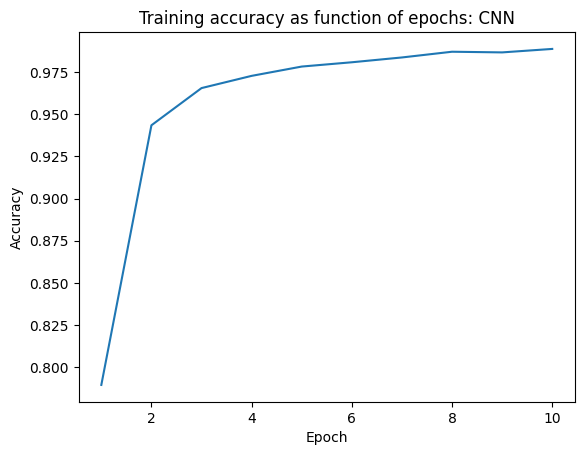

In [ ]:
CNN_acc = model_history.history['accuracy']
CNN_epochs = range(1,11)
plt.plot(CNN_epochs, CNN_acc)
plt.title('Training accuracy as function of epochs: CNN')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()